### Tract Boundary Masking

_Note: This notebook was previously used to mask tract boundaries, removing a duplicated tract number (specifically, the tract of O'Hare community area that lies in DuPage County). It no longer fully functions now that we have made the change, but we are retaining it in the repository for documentation purposes._

In [1]:
import os
import sys
sys.path[0] = os.path.join(os.path.abspath(''),'..')  # make sure we can import from our package

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from data_pipeline.fetch_census_data import acs5_aggregate 
from data_pipeline import spatial_operations as so
from data_pipeline import interactive_mapping as im
import numpy as np
import pandas as pd
from IPython.display import display
import geopandas as gpd
import os


In [3]:
tract_data = acs5_aggregate()[["estimated total population","tract"]]
tract_data['population'] = tract_data['estimated total population']
tract_data = tract_data.drop(columns='estimated total population')
tract_data.head()

,tract,population
0,630200,1825
1,580700,5908
2,590600,3419
3,600700,2835
4,611900,1639


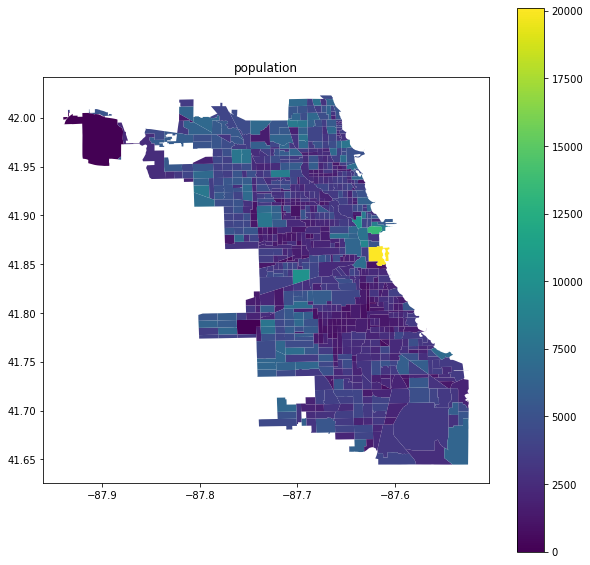

In [4]:
plt.rcParams['figure.figsize'] = [10, 10]  # add more space
so.simple_map(tract_data,'population','tract')

Nice. That's a correct map of Chicago tracts (note the clear lakeshore boundary) and correct 2019 population.

Now we want to rewrite the shapefile to have the right columns.

In [5]:
tract_shapefile = '/Users/drewkeller/Desktop/CS/broadbandequity/geo/tracts.shp'

In [6]:
geo = gpd.read_file(tract_shapefile)
geo

/Users/drewkeller/opt/anaconda3/envs/broadbandequity/lib/python3.8/site-packages/geopandas/array.py:85: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


,Shape_Leng,Shape_Area,SqMiles,GEOID2,tract,geometry
0,6102.900390,1.777035e+06,0.000000,76840801,840801,"MULTIPOLYGON (((-87.92000 41.95815, -87.92000 ..."
1,16035.054991,8.947394e+06,0.320945,59840300,840300,"POLYGON ((-87.67528 41.83039, -87.67552 41.830..."
2,14719.012184,8.946045e+06,0.320896,60840200,840200,"POLYGON ((-87.64160 41.84630, -87.64159 41.846..."
3,15186.400644,1.230614e+07,0.441424,34841100,841100,"POLYGON ((-87.62935 41.85295, -87.62935 41.852..."
4,10472.230299,6.731931e+06,0.241476,31841200,841200,"POLYGON ((-87.67849 41.85894, -87.67848 41.858..."
...,...,...,...,...,...,...
803,13232.831455,1.060785e+07,0.380506,63630300,630300,"POLYGON ((-87.70377 41.80082, -87.70375 41.800..."
804,10648.157958,7.085428e+06,0.254156,63630400,630400,"POLYGON ((-87.69380 41.79369, -87.69404 41.793..."
805,10637.040410,7.079999e+06,0.253961,63630500,630500,"POLYGON ((-87.68422 41.80115, -87.68422 41.800..."
806,10625.328587,7.059211e+06,0.253215,63630800,630800,"POLYGON ((-87.69360 41.78641, -87.69384 41.786..."


In [ ]:
geo = gpd.read_file('/Users/drewkeller/Desktop/ChTr0812/ChTr0812.shp')  # read pure Chicago tract shapefiles
geo

In [ ]:
# remove unneeded columns
geo = geo[[
    'Shape_Leng','Shape_Area','SqMiles','GEOID2','tract','geometry'
    ]]

In [ ]:
# rename columns
geo = geo.rename(columns={
    "tract" : "tract",})
geo

In [ ]:
# write to shapefile
geo.to_file(tract_shapefile)

In [ ]:
# reload to check
geo = gpd.read_file(tract_shapefile)
geo

In [ ]:
so.simple_map(geo,'population','tract')

But there's a problem still - we have duplicate tracts??

In [ ]:
len(geo.tract)

In [ ]:
len(set(geo.tract))

There's one duplicate. K.

In [ ]:
geo.drop_duplicates()

... but not an identical duplicate. Weird.

In [ ]:
wheres_that_pesky_duplicate = geo.groupby(by='tract').count().reset_index()
wheres_that_pesky_duplicate

In [ ]:
wheres_that_pesky_duplicate.geometry.argmax()

In [ ]:
wheres_that_pesky_duplicate.iloc[769]

In [ ]:
geo_sorted = geo.sort_values(by='tract').reset_index()
geo_sorted

In [ ]:
geo_sorted[769:771]

Hm. Based on Shape_Area and Shape_Leng, those are not really interchangeable. We don't like that. We're gonna have to map them and see which one is legit.

In [ ]:
duplicates = geo_sorted[geo_sorted.tract=='840000']
duplicates

In [ ]:
big_dup = duplicates[round(duplicates.Shape_Leng)==37281]
small_dup = duplicates[round(duplicates.Shape_Leng)==15230]

In [ ]:
so.simple_map(big_dup,'Shape_Area','tract')

In [ ]:
so.simple_map(small_dup,'Shape_Area','tract')

Where are these guys?

In [ ]:
geo.plot()

"small_dup" is the right one; it's the in Bridgeport / Armour Square area. "big_dup" is the left tract in O'Hare and is resident-less.

In [ ]:
# check we can filter "big_dup"
geo[(geo["tract"]=='840000') & (round(geo["Shape_Leng"])==37281)]


In [ ]:
# delete "big_dup"
geo = geo[(geo["tract"]!='840000') | (round(geo["Shape_Leng"])!=37281)]
geo

In [ ]:
# check there are now no duplicates
len(geo.tract) == len(set(geo.tract))

In [ ]:
so.simple_map(geo,'Shape_Leng','tract')

One more thing. We can't have a "community_area" column in the tract shapefiles - turns out that causes all kinds of problems in the aggregation function. Let's get rid of it.

In [ ]:
# write
geo.to_file(tract_shapefile)